In [1]:
import os
import random
from typing import Callable, Optional, Tuple, List

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import wandb

import matplotlib.pyplot as plt

In [2]:
# Setting random seed for all source of randomness
def set_seed(seed_value: int=42) -> None:
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed_value (int): The random seed value to be used.

    Returns:
        None
    """

    # Setting the random seed for numpy's random number generator
    np.random.seed(seed_value)

    # Setting the random seed for PyTorch's random number generator and the CUDA random number generator
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Setting the random seed for Python's built-in random library
    random.seed(seed_value)

seed_value = 42
set_seed(seed_value)

In [3]:
class LandmarkDataset(Dataset):
    """
    PyTorch Dataset class for loading images and their corresponding labels, including landmarks.
    """
    def __init__(
        self,
        root_dir: str,
        split: str = 'train',
        transform: Optional[Callable] = None,
        num_landmarks: int = 72
    ):
        """
        Initializes the LandmarkDataset.

        Args:
            root_dir (str): Root directory of the dataset.
            split (str): Dataset split to use ('train' or 'val').
            transform (Callable, optional): Transformations to apply to the images.
            num_landmarks (int): Number of landmarks per image.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.num_landmarks = num_landmarks

        # Directories for images and labels based on the split
        self.images_dir = os.path.join(root_dir, split, 'images')
        self.labels_dir = os.path.join(root_dir, split, 'labels')

        # Get a sorted list of all image files in the images directory
        self.image_files = sorted([
            f for f in os.listdir(self.images_dir) if f.endswith('.jpg')
        ])

        # Filter out image files that do not have a corresponding label file
        self.valid_image_files = []
        self.valid_label_files = []

        for img_file in self.image_files:
            label_file = img_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                self.valid_image_files.append(img_file)
                self.valid_label_files.append(label_file)
            else:
                print(f"Warning: Label file not found for image {img_file}, skipping.")

    def __len__(self) -> int:
        """
        Returns the total number of valid images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return len(self.valid_image_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label at the specified index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing the image tensor and label tensor.
        """
        # Load the image
        img_path = os.path.join(self.images_dir, self.valid_image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        else:
            # Default transformation: convert to tensor
            image = transforms.ToTensor()(image)

        # Load the label
        label_path = os.path.join(self.labels_dir, self.valid_label_files[idx])
        with open(label_path, 'r') as f:
            label_data = f.readline().strip().split()

        # Parse label data
        class_id = int(label_data[0])  # Class ID
        bbox = np.array(label_data[1:5], dtype=np.float32)  # Bounding box: cx, cy, w, h
        landmarks = np.array(label_data[5:], dtype=np.float32)  # Landmarks: x1, y1, ..., xn, yn

        # Concatenate class ID, bounding box, and landmarks into a single label array
        label = np.concatenate(([class_id], bbox, landmarks))

        # Convert label array to a tensor
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return image, label_tensor


In [4]:
# Define transformations for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize images to 416x416
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # Additional transformations can be added here
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the training dataset
train_dataset = LandmarkDataset(
    root_dir='/Users/jocareher/Downloads/lmks_data/lmks_data',
    split='train',
    transform=train_transform,
    num_landmarks=72  # Specify the number of landmarks
)

# Create the validation dataset
val_dataset = LandmarkDataset(
    root_dir='/Users/jocareher/Downloads/lmks_data/lmks_data',
    split='val',
    transform=val_transform,
    num_landmarks=72
)

# Create the DataLoader for the training dataset
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,  # Adjust batch size as needed
    shuffle=True,  # Shuffle the data
    num_workers=0  # Number of subprocesses for data loading
)

# Create the DataLoader for the validation dataset
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)


# Iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([16, 3, 416, 416])
Batch of labels shape: torch.Size([16, 149])


In [5]:

# Function to denormalize the image
def denormalize(image, mean, std):
    """Denormalizes a tensor image using the provided mean and std."""
    image = image.clone()  # Clone to avoid modifying the original image
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # t = t * std + mean
    return image

def show_batch_with_landmarks(dataloader: DataLoader, num_images: int, img_size: int = 224) -> None:
    """
    Displays a batch of images with corresponding landmarks, denormalizing images before plotting.
    
    Args:
        dataloader: PyTorch DataLoader to extract the images and labels from.
        num_images: Number of images to display.
        img_size: Size of the images, for correctly plotting landmarks (default is 224).
    """
    # Specify the mean and std used during normalization (from the transformation)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Get a batch of images and labels
    for images, labels in dataloader:
        images = images[:num_images]  # Select the first num_images
        labels = labels[:num_images]  # Select the corresponding labels

        # Create the plot
        fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
        if num_images == 1:
            axes = [axes]  # Ensure axes is a list even for a single image

        for i, (image, label) in enumerate(zip(images, labels)):
            # Denormalize the image before displaying
            image = denormalize(image, mean, std)
            image = image.permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # Convert to numpy for plotting
            axes[i].imshow(image)
            axes[i].axis('off')

            # Extract class index and bounding box (cx, cy, w, h)
            class_id = int(label[0].item())
            cx, cy, w, h = label[1:5].cpu().numpy()

            # Convert normalized bbox to pixel coordinates
            x1 = int((cx - w / 2) * img_size)
            y1 = int((cy - h / 2) * img_size)
            x2 = int((cx + w / 2) * img_size)
            y2 = int((cy + h / 2) * img_size)

            # Draw the bounding box (optional, you can remove this part if you don't want the bbox)
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
            axes[i].add_patch(rect)

            # Plot landmarks (keypoints)
            keypoints = label[5:].cpu().numpy().reshape(-1, 2)
            for (x, y) in keypoints:
                x_pixel = int(x * img_size)
                y_pixel = int(y * img_size)
                axes[i].scatter(x_pixel, y_pixel, color='blue', s=10)

            # Add the class ID in the bottom-left corner
            axes[i].text(10, img_size - 10, f"Class: {class_id}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.tight_layout()
        plt.show()

        break  # Only show one batch


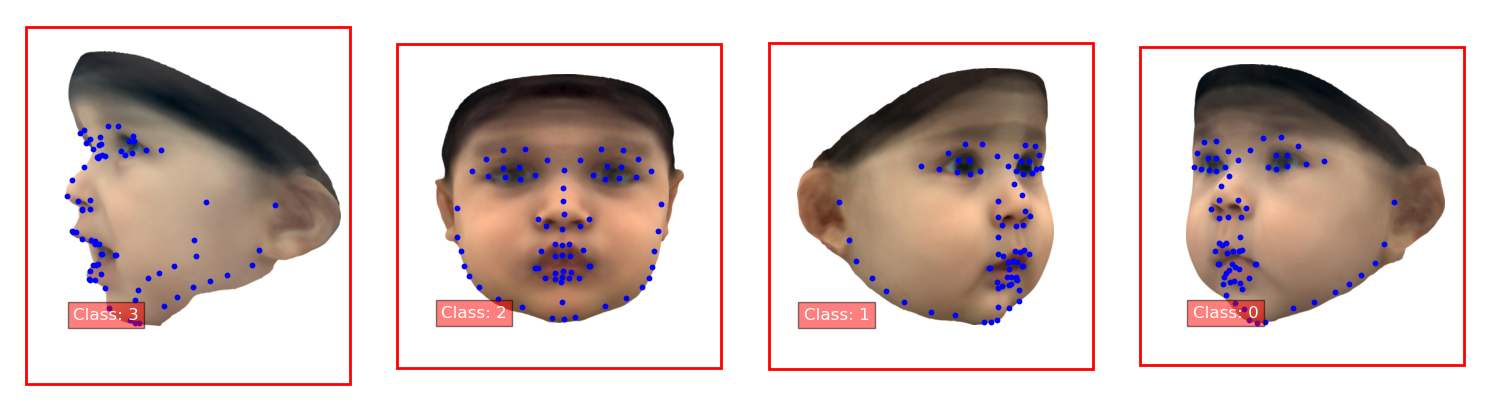

In [6]:
# Assuming train_loader is already defined from the previous Dataset and DataLoader
show_batch_with_landmarks(train_loader, num_images=4, img_size=416)

In [7]:
def get_default_device() -> torch.device:
    """
    Determines and returns the default device for PyTorch computations.

    This function checks for the availability of CUDA (for NVIDIA GPUs), 
    MPS (for Apple's Sillicon chips), or defaults to CPU if none are available.

    Returns:
        A torch.device object representing the default device. If CUDA is available, 
        it will return a CUDA device, if MPS is available it will return an MPS device, 
        and if neither are available, it will return a CPU device.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")  # MPS is available for Mac (M1/M2)
    else:
        return torch.device("cpu")


device = get_default_device()
device

device(type='mps')

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block that includes a Conv2d layer, BatchNorm, and LeakyReLU activation.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        use_bn: bool = True
    ):
        """
        Initializes the ConvBlock.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel.
            stride (int): Stride of the convolution.
            padding (int): Padding added to both sides of the input.
            use_bn (bool): Whether to use Batch Normalization.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=not use_bn  # Bias is not needed if BatchNorm is used
        )
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ConvBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying convolution, batch norm, and activation.
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class ResidualBlock(nn.Module):
    """
    A residual block that consists of two convolutional layers with a skip connection.
    """
    def __init__(self, channels: int):
        """
        Initializes the ResidualBlock.

        Args:
            channels (int): Number of channels in the input and output.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels // 2, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBlock(channels // 2, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the residual block.
        """
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x += residual  # Skip connection
        return x

class Darknet53(nn.Module):
    """
    The Darknet-53 backbone used in YOLOv3 for feature extraction.
    """
    def __init__(self):
        """
        Initializes the Darknet53 model.
        """
        super(Darknet53, self).__init__()

        # Initial convolution layers
        self.conv1 = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvBlock(32, 64, kernel_size=3, stride=2, padding=1)

        # Residual blocks and convolution layers
        self.residual_block1 = self._make_layer(64, num_blocks=1)
        self.conv3 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1)
        self.residual_block2 = self._make_layer(128, num_blocks=2)
        self.conv4 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual_block3 = self._make_layer(256, num_blocks=8)
        self.conv5 = ConvBlock(256, 512, kernel_size=3, stride=2, padding=1)
        self.residual_block4 = self._make_layer(512, num_blocks=8)
        self.conv6 = ConvBlock(512, 1024, kernel_size=3, stride=2, padding=1)
        self.residual_block5 = self._make_layer(1024, num_blocks=4)

    def _make_layer(self, channels: int, num_blocks: int) -> nn.Sequential:
        """
        Creates a sequence of residual blocks.

        Args:
            channels (int): Number of channels in the blocks.
            num_blocks (int): Number of residual blocks to create.

        Returns:
            nn.Sequential: A sequential container of residual blocks.
        """
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(channels))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Darknet53 model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Feature maps at different scales.
        """
        x = self.conv1(x)              # Output: [batch_size, 32, 416, 416]
        x = self.conv2(x)              # Output: [batch_size, 64, 208, 208]
        x = self.residual_block1(x)    # Output: [batch_size, 64, 208, 208]
        x = self.conv3(x)              # Output: [batch_size, 128, 104, 104]
        x = self.residual_block2(x)    # Output: [batch_size, 128, 104, 104]
        x = self.conv4(x)              # Output: [batch_size, 256, 52, 52]
        x = self.residual_block3(x)    # Output: [batch_size, 256, 52, 52]
        route1 = x                     # Assign route1 here (52x52)
        x = self.conv5(x)              # Output: [batch_size, 512, 26, 26]
        x = self.residual_block4(x)    # Output: [batch_size, 512, 26, 26]
        route2 = x                     # Assign route2 here (26x26)
        x = self.conv6(x)              # Output: [batch_size, 1024, 13, 13]
        x = self.residual_block5(x)    # Output: [batch_size, 1024, 13, 13]
        return route1, route2, x       # Return feature maps at different scales


class ScalePrediction(nn.Module):
    """
    Scale prediction layer used in YOLOv3 for predicting bounding boxes, objectness scores, class scores, and landmarks.
    """
    def __init__(self, in_channels: int, num_classes: int, num_landmarks: int):
        """
        Initializes the ScalePrediction layer.

        Args:
            in_channels (int): Number of input channels.
            num_classes (int): Number of object classes.
            num_landmarks (int): Number of landmarks per object.
        """
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            ConvBlock(in_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(
                in_channels * 2,
                # For each anchor box: objectness score + bbox (4) + landmarks (2 * num_landmarks) + class scores
                3 * (1 + 4 + 2 * num_landmarks + num_classes),
                kernel_size=1,
                stride=1,
                padding=0
            )
        )
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ScalePrediction layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Predictions reshaped to (batch_size, anchors, grid_size, grid_size, prediction_size)
        """
        batch_size = x.size(0)
        prediction = self.pred(x)
        prediction = prediction.permute(0, 2, 3, 1).contiguous()  # Rearrange dimensions
        grid_size = prediction.size(1)
        prediction = prediction.view(
            batch_size,
            grid_size,
            grid_size,
            3,  # Number of anchor boxes
            1 + 4 + 2 * self.num_landmarks + self.num_classes  # Prediction components
        )
        prediction = prediction.permute(0, 3, 1, 2, 4)  # (batch_size, anchors, grid_size, grid_size, prediction_size)
        return prediction

class YOLOv3Landmark(nn.Module):
    """
    YOLOv3 model adapted for landmark detection.
    """
    def __init__(self, num_classes: int, num_landmarks: int):
        """
        Initializes the YOLOv3Landmark model.

        Args:
            num_classes (int): Number of object classes.
            num_landmarks (int): Number of landmarks per object.
        """
        super(YOLOv3Landmark, self).__init__()
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks

        # Backbone network (Darknet-53)
        self.backbone = Darknet53()

        # Convolutional sets and scale predictions for three different scales
        self.conv_set1 = self._make_conv_set(1024, 512)
        self.scale_pred_1 = ScalePrediction(512, num_classes, num_landmarks)

        self.conv_up_1 = ConvBlock(512, 256, kernel_size=1, stride=1, padding=0)
        self.upsample_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_set2 = self._make_conv_set(768, 256)
        self.scale_pred_2 = ScalePrediction(256, num_classes, num_landmarks)

        self.conv_up_2 = ConvBlock(256, 128, kernel_size=1, stride=1, padding=0)
        self.upsample_2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_set3 = self._make_conv_set(384, 128)
        self.scale_pred_3 = ScalePrediction(128, num_classes, num_landmarks)

    def _make_conv_set(self, in_channels: int, out_channels: int) -> nn.Sequential:
        """
        Creates a convolutional set used in YOLOv3.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.

        Returns:
            nn.Sequential: A sequential container of convolutional layers.
        """
        return nn.Sequential(
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        """
        Forward pass of the YOLOv3Landmark model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            List[torch.Tensor]: List of predictions at different scales.
        """
        # Backbone network to extract feature maps
        route1, route2, x = self.backbone(x)  # route1: 52x52, route2: 26x26, x: 13x13

        # First scale prediction (small scale objects)
        x = self.conv_set1(x)                 # x: 13x13
        pred_small = self.scale_pred_1(x)     # Prediction at 13x13 scale

        # Upsample and concatenate for second scale
        x = self.conv_up_1(x)                 # x: remains 13x13
        x = self.upsample_1(x)                # x: upsampled to 26x26
        x = torch.cat([x, route2], dim=1)     # x and route2 both are 26x26

        # Second scale prediction (medium scale objects)
        x = self.conv_set2(x)                 # x: 26x26
        pred_medium = self.scale_pred_2(x)    # Prediction at 26x26 scale

        # Upsample and concatenate for third scale
        x = self.conv_up_2(x)                 # x: remains 26x26
        x = self.upsample_2(x)                # x: upsampled to 52x52
        x = torch.cat([x, route1], dim=1)     # x and route1 both are 52x52

        # Third scale prediction (large scale objects)
        x = self.conv_set3(x)                 # x: 52x52
        pred_large = self.scale_pred_3(x)     # Prediction at 52x52 scale

        return [pred_large, pred_medium, pred_small]  # Return predictions from largest to smallest scale


model = YOLOv3Landmark(num_classes=5, num_landmarks=72).to(device)
print(model)
# Printing a summary using torchinfo for YOLOv3Landmark model
# summary(
#     model=model,
#     input_size=(16, 3, 224, 224),  # make sure this is "input_size", not "input_shape"
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )

YOLOv3Landmark(
  (backbone): Darknet53(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (residual_block1): Sequential(
      (0): ResidualBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
# Get a batch of images
images, labels = next(iter(train_loader))
images = images.to(device)

# Forward pass
predictions = model(images)
print(f"Prediction scales: {[pred.shape for pred in predictions]}")


Prediction scales: [torch.Size([16, 3, 52, 52, 154]), torch.Size([16, 3, 26, 26, 154]), torch.Size([16, 3, 13, 13, 154])]


In [23]:
class LandmarkLoss(nn.Module):
    """
    Loss function for landmarks in YOLOv3, considering anchors.
    """
    def __init__(self, num_classes: int, num_landmarks: int, anchors: list, device: torch.device):
        """
        Initializes the LandmarkLoss.

        Args:
            num_classes (int): Number of object classes.
            num_landmarks (int): Number of landmarks per object.
            anchors (list): Anchors for each scale.
            device (torch.device): Device to run on.
        """
        super(LandmarkLoss, self).__init__()
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks
        self.anchors = anchors  # List of anchors for each scale
        self.device = device
        self.mse = nn.MSELoss()
        self.sigmoid = nn.Sigmoid()

    def forward(self, predictions: list, targets: torch.Tensor) -> torch.Tensor:
        """
        Calculates the landmark loss.

        Args:
            predictions (list): List of predictions at each scale.
            targets (torch.Tensor): Ground truth labels of shape (batch_size, label_length)

        Returns:
            torch.Tensor: Total landmark loss.
        """
        total_loss = 0
        batch_size = targets.size(0)
        num_scales = len(predictions)

        # Process each scale
        for scale_idx in range(num_scales):
            prediction = predictions[scale_idx]
            batch_size_pred, num_anchors, grid_size, grid_size_pred, prediction_size = prediction.shape

            anchors = torch.tensor(self.anchors[scale_idx], device=self.device).view(num_anchors, 1, 1, 2)

            # For each image in the batch
            for b in range(batch_size):
                target = targets[b]  # Shape: (1 + 4 + 2*num_landmarks)
                class_id = target[0]
                cx, cy, w, h = target[1:5]
                landmarks = target[5:]  # Shape: (2*num_landmarks,)

                # Skip if class_id is negative (indicates no object)
                if class_id < 0:
                    continue

                # Determine which grid cell the object belongs to
                grid_x = min(int(cx * grid_size), grid_size - 1)
                grid_y = min(int(cy * grid_size), grid_size - 1)

                # Adjust ground truth bbox to grid cell
                gt_bbox = torch.tensor(
                    [cx * grid_size - grid_x, cy * grid_size - grid_y, w * grid_size, h * grid_size],
                    device=self.device
                )

                # Compute IoU between gt_bbox and anchors
                ious = []
                for anchor_idx in range(num_anchors):
                    anchor = anchors[anchor_idx, 0, 0, :]  # Width and height
                    # Anchor bbox centered at (0.5, 0.5) in the cell
                    anchor_bbox = torch.tensor([0.5, 0.5, anchor[0] * grid_size, anchor[1] * grid_size], device=self.device)
                    iou_score = self.calculate_iou(gt_bbox, anchor_bbox)
                    ious.append(iou_score.item())

                # Select the best anchor
                best_anchor_idx = ious.index(max(ious))

                # Extract predicted landmarks at the corresponding location
                pred_landmarks = prediction[b, best_anchor_idx, grid_y, grid_x, 5 + self.num_classes:]
                pred_landmarks = self.sigmoid(pred_landmarks)  # Landmarks are normalized between 0 and 1

                # Compute landmark loss
                landmark_loss = self.mse(pred_landmarks, landmarks.to(self.device))

                total_loss += landmark_loss

        total_loss = total_loss / batch_size  # Average over batch size

        return total_loss

    @staticmethod
    def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
        """
        Calculates the Intersection over Union (IoU) between two boxes.

        Args:
            box1 (torch.Tensor): First box [x_center, y_center, width, height].
            box2 (torch.Tensor): Second box [x_center, y_center, width, height].

        Returns:
            torch.Tensor: IoU score.
        """
        # Convert from center to corner coordinates
        box1_x1 = box1[0] - box1[2] / 2
        box1_y1 = box1[1] - box1[3] / 2
        box1_x2 = box1[0] + box1[2] / 2
        box1_y2 = box1[1] + box1[3] / 2

        box2_x1 = box2[0] - box2[2] / 2
        box2_y1 = box2[1] - box2[3] / 2
        box2_x2 = box2[0] + box2[2] / 2
        box2_y2 = box2[1] + box2[3] / 2

        # Intersection
        inter_x1 = max(box1_x1, box2_x1)
        inter_y1 = max(box1_y1, box2_y1)
        inter_x2 = min(box1_x2, box2_x2)
        inter_y2 = min(box1_y2, box2_y2)
        inter_area = max(inter_x2 - inter_x1, torch.tensor(0.0)) * max(inter_y2 - inter_y1, torch.tensor(0.0))

        # Union
        box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
        union_area = box1_area + box2_area - inter_area

        iou = inter_area / (union_area + 1e-6)
        return iou


In [24]:
def compute_med(predictions, targets, num_classes, num_landmarks, anchors, device):
    """
    Computes the Mean Euclidean Distance (MED) between predicted landmarks and ground truth landmarks.

    Args:
        predictions: List of predictions at each scale.
        targets: Ground truth labels of shape (batch_size, label_length)
        num_classes: Number of classes.
        num_landmarks: Number of landmarks per object.
        anchors: Anchors for each scale.
        device: Device to run on.

    Returns:
        Mean Euclidean Distance over the batch.
    """
    batch_size = targets.size(0)
    total_distance = 0.0
    num_samples = 0

    for b in range(batch_size):
        target = targets[b]  # Shape: (1 + 4 + 2*num_landmarks)
        class_id = target[0]
        cx, cy, w, h = target[1:5]
        gt_landmarks = target[5:].view(-1, 2).to(device)  # Shape: (num_landmarks, 2)

        # Skip if class_id is negative (indicates no object)
        if class_id < 0:
            continue

        found = False

        for scale_idx in range(len(predictions)):
            prediction = predictions[scale_idx]
            batch_size_pred, num_anchors, grid_size, grid_size_pred, prediction_size = prediction.shape

            anchors_scale = torch.tensor(anchors[scale_idx], device=device).view(num_anchors, 1, 1, 2)

            grid_x = min(int(cx * grid_size), grid_size - 1)
            grid_y = min(int(cy * grid_size), grid_size - 1)

            # Adjust ground truth bbox to grid cell
            gt_bbox = torch.tensor(
                [cx * grid_size - grid_x, cy * grid_size - grid_y, w * grid_size, h * grid_size],
                device=device
            )

            # Compute IoU between gt_bbox and anchors
            ious = []
            for anchor_idx in range(num_anchors):
                anchor = anchors_scale[anchor_idx, 0, 0, :]  # Width and height
                # Anchor bbox centered at (0.5, 0.5) in the cell
                anchor_bbox = torch.tensor([0.5, 0.5, anchor[0] * grid_size, anchor[1] * grid_size], device=device)
                iou_score = LandmarkLoss.calculate_iou(gt_bbox, anchor_bbox)
                ious.append(iou_score.item())

            # Select the best anchor
            best_anchor_idx = ious.index(max(ious))

            # Extract predicted landmarks at the corresponding location
            pred_landmarks = prediction[b, best_anchor_idx, grid_y, grid_x, 5 + num_classes:]
            pred_landmarks = pred_landmarks.view(-1, 2)  # Shape: (num_landmarks, 2)
            pred_landmarks = torch.sigmoid(pred_landmarks)  # Normalize between 0 and 1

            # Compute Euclidean distance
            distance = torch.norm(pred_landmarks - gt_landmarks, dim=1).mean()
            total_distance += distance.item()
            num_samples += 1
            found = True
            break  # Only consider the best scale

        if not found:
            continue

    if num_samples > 0:
        med = total_distance / num_samples
    else:
        med = None

    return med


In [18]:
def train_step(
    model: nn.Module,
    train_dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    num_classes: int,
    num_landmarks: int,
    anchors: list,
    device: torch.device,
) -> Tuple[float, float]:
    """
    Trains a PyTorch model for one epoch.

    Returns:
        Average training loss over the epoch.
        Average MED over the epoch.
    """
    if device.type == "cuda":
        torch.cuda.empty_cache()

    model.train()
    total_loss = 0.0
    total_med = 0.0
    num_batches = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        predictions = model(images)

        # Compute loss
        loss = loss_fn(predictions, labels)

        # Zero gradients before backward pass
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Compute MED for accuracy
        med = compute_med(predictions, labels, num_classes, num_landmarks, anchors, device)
        if med is not None:
            total_med += med
            num_batches += 1

    avg_loss = total_loss / len(train_dataloader)
    if num_batches > 0:
        avg_med = total_med / num_batches
    else:
        avg_med = None

    return avg_loss, avg_med



In [19]:
def val_step(
    model: nn.Module,
    val_dataloader: DataLoader,
    loss_fn: nn.Module,
    num_classes: int,
    num_landmarks: int,
    anchors: list,
    device: torch.device,
) -> Tuple[float, float]:
    """
    Validates a PyTorch model for one epoch.

    Returns:
        Average validation loss over the epoch.
        Average MED over the epoch.
    """
    if device.type == "cuda":
        torch.cuda.empty_cache()

    model.eval()
    total_loss = 0.0
    total_med = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)

            # Compute loss
            loss = loss_fn(predictions, labels)

            # Accumulate loss
            total_loss += loss.item()

            # Compute MED for accuracy
            med = compute_med(predictions, labels, num_classes, num_landmarks, anchors, device)
            if med is not None:
                total_med += med
                num_batches += 1

    avg_loss = total_loss / len(val_dataloader)
    if num_batches > 0:
        avg_med = total_med / num_batches
    else:
        avg_med = None

    return avg_loss, avg_med



In [27]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            if self.verbose:
                if self.best_loss is None:
                    print(f"Validation loss decreased (N/A --> {val_loss:.6f}). Saving model...")
                else:
                    print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True



In [28]:
def train_loop(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    num_classes: int,
    num_landmarks: int,
    anchors: list,
    device: torch.device,
    epochs: int,
    early_stopping: EarlyStopping = None,
    record_metrics: bool = False,
    project: str = "My_WandB_Project",
    run_name: str = "My_Run"
) -> dict[str, List]:
    """
    Trains and validates a PyTorch model over multiple epochs.

    Returns:
        Dictionary containing training and validation losses and MED per epoch.
    """
    # Initialize results dictionary
    results = {"train_loss": [], "val_loss": [], "train_med": [], "val_med": []}

    # Move model to device
    model.to(device)

    # Configure wandb if recording metrics
    if record_metrics:
        wandb.init(project=project, name=run_name)
        wandb.watch(model, loss_fn, log="all")
    else:
        wandb.init(mode="disabled")  # Disable wandb logging if not recording metrics

    # Track the best validation loss
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")

        # Training step
        train_loss, train_med = train_step(
            model=model,
            train_dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            num_classes=num_classes,
            num_landmarks=num_landmarks,
            anchors=anchors,
            device=device
        )

        # Validation step
        val_loss, val_med = val_step(
            model=model,
            val_dataloader=val_dataloader,
            loss_fn=loss_fn,
            num_classes=num_classes,
            num_landmarks=num_landmarks,
            anchors=anchors,
            device=device
        )

        # Append losses and MEDs to results
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        results["train_med"].append(train_med)
        results["val_med"].append(val_med)

        # Print epoch results
        print(
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"Train MED: {train_med:.4f} | Val MED: {val_med:.4f}"
        )

        # Log metrics to wandb
        wandb.log(
            {
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Val Loss": val_loss,
                "Train MED": train_med,
                "Val MED": val_med,
            }
        )

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model weights
            torch.save(model.state_dict(), f"best_model_epoch_{epoch}.pth")
            print(f"Validation loss decreased. Saving model weights from epoch {epoch}.")

        # Early Stopping check
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered. Stopping training.")
                # Load the best model weights
                model.load_state_dict(early_stopping.best_model_weights)
                break

    # Finish wandb run
    wandb.finish()

    return results



In [25]:
# Hyperparameters
num_classes = 5  # Adjust based on your dataset
num_landmarks = 72
learning_rate = 1e-4
batch_size = 16
image_size = 416
epochs = 1

# Anchor boxes for each feature map scaled between 0 and 1
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = LandmarkLoss(num_classes=num_classes, num_landmarks=num_landmarks, anchors=ANCHORS, device=device)
# Set up EarlyStopping (e.g., patience of 5 epochs)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Start training
results = train_loop(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_classes=num_classes,
    num_landmarks=num_landmarks,
    anchors=ANCHORS,
    device=device,
    epochs=epochs,
    early_stopping=early_stopping,
    record_metrics=True,  # Set to False if you don't want to log to wandb
    project='YOLOv3-Landmark-Detection',
    run_name='run_3'
)

Epoch 1/5
Train Loss: 0.2400 | Val Loss: 0.2497 | Train MED: 0.3695 | Val MED: 0.3718
Validation loss decreased. Saving model weights from epoch 1.


TypeError: unsupported format string passed to NoneType.__format__